In [1]:
import sys
sys.path.append('../')

import os
import torch

from dataset import PBDLDataset
from sampler import PBDLConstantBatchSampler
from dataloader import PBDLDataLoader

import numpy as np
import matplotlib.pyplot as plt

# A short example: transonic cylinder flow

## Dataset and Dataloader

In [2]:
import examples.tcf.net_small as net_small

TIME_STEPS = 10
BATCH_SIZE = 3
LR = 0.0001
EPOCHS = 5

dataset = PBDLDataset(
    "transonic-cylinder-flow-tiny", # dataset name
    time_steps=TIME_STEPS, # time steps between input and target frame
    simulations=[0,1], # use only the first two simulations
    step_size=3, # start_offset=100, end_offset=100,
    normalize=True
)

loader = PBDLDataLoader(dataset, # batch_sampler=...,
    batch_size=BATCH_SIZE, shuffle=True)

net = net_small.NetworkSmall()
criterionL2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0.0)

Loading 'transonic-cylinder-flow-tiny'...
Successfully loaded transonic-cylinder-flow-tiny with 2 simulations and 330 samples each.
Calculating normalization data...


A PBDLDataset instance provides the data samples to the data loader and must be initialized with the dataset name and the time steps between input and target sample. Due to the specification of `simulations`, only the first two simulations are used. As the transonic-cylinder-flow dataset is quite large for quick training, it is thinned out using the parameter `step_size` (every third sample is used). Additionally, you could use `start_offset` and `end_offset` to discard a (possibly uninteresting) start/end sequence of samples. Optionally, it is possible to specify whether the data should be normalized.

A PBDLDataLoader instance takes the dataset as input and prepares the samples for later training with the CNN (e.g. blows up the constants into layers). A loader instance is iterable, returning batches of the specified `batch_size`. When integrating solvers into deep learning, it may be required for samples in a batch to have the same constants; this is ensured by the PBDLConstantBatchSampler (not used in this example).

## Training

In [3]:
for epoch in range(EPOCHS):
    for i, (input, target) in enumerate(loader):

        net.zero_grad()
        output = net(input)

        loss = criterionL2(output, target)
        loss.backward()
        optimizer.step()

    print(f"epoch { epoch }, loss { loss.item() }")

epoch 0, loss 1.2560150623321533
epoch 1, loss 0.47072601318359375
epoch 2, loss 0.3344712257385254
epoch 3, loss 0.27924230694770813
epoch 4, loss 0.27085593342781067


## Evaluation

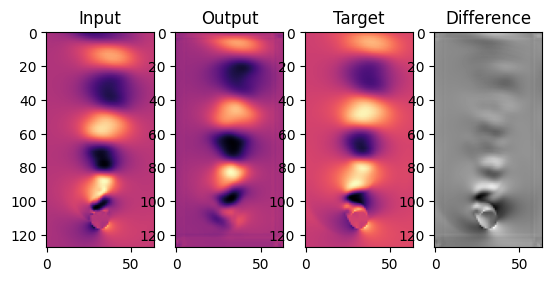

In [4]:
net.eval()

input, target = next(iter(loader))
output = net(input)

input = input.numpy()
target = target.numpy()
output = output.detach().numpy()

plt.subplot(1, 4, 1)
plt.imshow(np.flip(input[0, 1, ...], axis=-2), cmap="magma")
plt.title("Input")

plt.subplot(1, 4, 2)
plt.imshow(np.flip(output[0, 1, ...], axis=-2), cmap="magma")
plt.title("Output")

plt.subplot(1, 4, 3)
plt.imshow(np.flip(target[0, 1, ...], axis=-2), cmap="magma")
plt.title("Target")

diff = target[0, 1, ...] - output[0, 1, ...]
plt.subplot(1, 4, 4)
plt.imshow(np.flip(diff, axis=-2), cmap="gray")
plt.title("Difference")

plt.show()

# Comprehensive example: solver-in-the-loop

The following example shows how to use
* the PBDLConstantBatchSampler
* PyTorch-PhiFlow tensor conversion

In [5]:
from examples.ks.ks_networks import ConvResNet1D
from examples.ks.ks_solver import DifferentiableKS

# training parameters
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 4

# solver parameters
RES = 48
TIMESTEP = 0.5
DOMAIN_SIZE_BASE = 8
PREDHORZ = 5

device = "cuda:0" if torch.cuda.is_available() else "cpu"

diff_ks = DifferentiableKS(resolution=RES, dt=TIMESTEP)

dataset = PBDLDataset(
    "ks-dataset",
    time_steps=PREDHORZ,
    step_size=20,
    time_stepping=True,
    normalize=False,
)

batch_sampler = PBDLConstantBatchSampler(dataset, BATCH_SIZE, group_constants=[0]) # group after first constant
dataloader = PBDLDataLoader(dataset, batch_sampler=batch_sampler)

net = ConvResNet1D(16, 3, device=device)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss = torch.nn.MSELoss()

No precomputed normalization data found on server.
Loading 'ks-dataset'...
Successfully loaded ks-dataset with 6 simulations and 259 samples each.


Notice that the dataset is initialized with the `time_stepping` flag. The dataset now not only supplies the initial and the target frame, but also all frames in between.

We also use the PBDLConstantBatchSampler to ensure that all samples in a batch have the same constants. This is necessary because for each batch only one domain size can be passed to the solver function. You can use `group_constants` to specify which constants should be considered for grouping into batches.

In [6]:
for epoch in range(EPOCHS):
    for i, (input, targets) in enumerate(dataloader):

        input = input.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        domain_size = input[0][1][0].item()

        inputs = [input]
        outputs = []

        for _ in range(PREDHORZ):
            output_solver = diff_ks.etd1(
                dataset.to_phiflow(inputs[-1]), DOMAIN_SIZE_BASE * domain_size
            )

            correction = diff_ks.dt * net(inputs[-1])

            output_combined = dataset.from_phiflow(output_solver) + correction

            outputs.append(output_combined)
            inputs.append(dataset.cat_constants(outputs[-1], inputs[0]))

        outputs = torch.stack(outputs, axis=1)

        loss_value = loss(outputs, targets)
        loss_value.backward()
        optimizer.step()

    print(f"epoch { epoch }, loss {(loss_value.item()*10000.) :.3f}")

epoch 0, loss 740.379
epoch 1, loss 504.112
epoch 2, loss 350.801
epoch 3, loss 248.268


When a solver is included in the training process, it is necessary to convert between PyTorch tensors and solver tensors and possibly add or remove constant layers. For this purpose, the PBDLDataset class provides the auxiliary methods `to_phiflow`, `from_phiflow` and `cat_constants` to convert between tensor types and to add constant layers to the solver output. `cat_constants` function takes a reference tensor as input, from which it copies the constant layers.

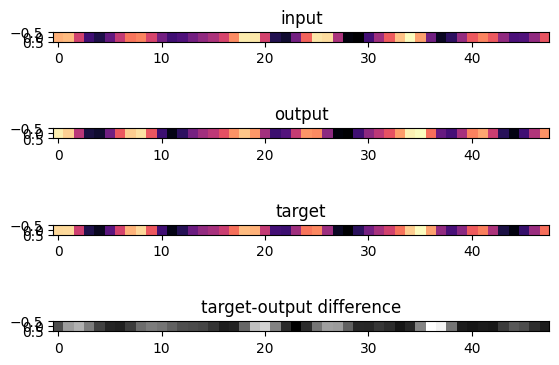

In [7]:
input, targets = next(iter(dataloader))

domain_size = input[0][1][0].item()

inputs = [input]
outputs = []

for _ in range(PREDHORZ):
    output_solver = diff_ks.etd1(
        dataset.to_phiflow(inputs[-1]), DOMAIN_SIZE_BASE * domain_size
    )
    output_combined = dataset.from_phiflow(output_solver) + diff_ks.dt * net(inputs[-1])

    outputs.append(output_combined)
    inputs.append(dataset.cat_constants(outputs[-1], inputs[0]))

outputs = torch.stack(outputs, axis=1)

input = inputs[0][0][0:1, ...].detach().numpy()
output = outputs[0][-1].detach().numpy()
target = targets[0][-1]

plt.subplot(4, 1, 1)
plt.imshow(input, cmap="magma", aspect=1)
plt.title("input")

plt.subplot(4, 1, 2)
plt.imshow(output, cmap="magma", aspect=1)
plt.title("output")

plt.subplot(4, 1, 3)
plt.imshow(target, cmap="magma", aspect=1)
plt.title("target")

diff = target - output
plt.subplot(4, 1, 4)
plt.imshow(diff, cmap="gray", aspect=1)
plt.title("target-output difference")

plt.show()

# Dataset structure

A `.npz`-dataset file are just two numpy arrays: the data and constants. The data array has the structure `[sim][frame][field][spatial dims...]` for single-file datasets and `[frame][field][spatial dims...]` for partitioned datasets. The constant array has the structure `[sim][const]` for single-file datasets and `[const]` for partitioned datasets. You can use the following two lines to save your arrays as a `.npz`-file:
```
combined = {"data": data, "constants": constants}
np.savez("dataset.npz", **combined)
```

In order for partitioned data sets to be recognized, they must have a certain file structure. There must be a directory, e.g. `my-dataset`, which contains several files with the name `my-dataset-[i].npz`, where i is an incremental index. In addition, there may be a file `norm_data.npz` in which the data required for normalization is stored.

# Local datasets

If you want to load your own dataset, you can add a `datasets.json` file in the working directory with the following structure:
```
{
    "dataset-name": {
        "path": "./path/to/dataset.npz",
        "fields": "VVdp",
        "field_desc" : ["channel 1", "channel 2", "channel 3"],
        "constant_desc" : ["mach number", "reynolds number"]
    }
}
```
The path to your local `.npz`-file is specified by `path`. If extension `.npz` is omitted the dataset is interpreted as a partitioned dataset. In this case, it is necessary the specify an additional attribute `num_part` for the number of partitions. `fields` contains information about the type of physical field in the form of a string, e.g. VVdp (velocity x, velocity y, density, pressure). Consecutive identical letters indicate that a physical field consists of several indices (vector field). This information affects how normalization is applied: For vector fields, the vector norm is applied first before the standard deviation is calculated.